In [1]:
import dolfin
import bempp.api
from bempp.api.external.fenics import FenicsOperator
from dolfin_utils.meshconvert import meshconvert
import numpy as np
from bempp.api.external import fenics
from scipy.sparse.linalg import cg, minres
import pylab as plt
import time

from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
from bempp.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator

from bempp.api.operators.boundary import sparse, laplace, modified_helmholtz
from bempp.api.operators.potential import laplace as lp
 
tol = 1e-06

#Entry data
Q = np.array([1.0,1.0,0.75])
PC=np.array([[1,0,0],[0.7,0.7,0],[-0.5,-0.5,0]])
R = np.array([2., 2., 2.])
w = 0.150 #kappa
es = 80.  #[-]
em = 4.    #[-]

ec = 1.602176e-19 #[C]
kb = 1.380648e-23 #[J/K]
T  = 300 #[K]
S1 = 1 #(ec/(kb*T))  #38.681 [C/J]

u_error = []
lambda_error = []

solv_error = []

mesh_size = []
iter_num = []
time_solve = []

grid_size = [0, 1, 2, 3]#, 4]

#Analytical solvation energy#
from an_solution import an_P
Ri = 2

G2 = an_P(Q, PC, em, es, Ri, w, Ri , 10)
print(G2)

# Solution for regularisation
@bempp.api.real_callable(jit=False)
def U_c(x, n, domain_index, result):
    global Q,PC,em,S1
    result[:] = (S1 / (4.*np.pi*em))  * np.sum( Q / np.linalg.norm( x - PC, axis=1))

@bempp.api.real_callable(jit=False)
def dU_c(x, n, domain_index, result):
    global Q,PC,em,S1
    result[:] = -(S1/(4.*np.pi*em))   * np.sum( np.dot( x - PC , n)  * Q / (np.linalg.norm( x - PC , axis=1)**3) )



-164.58633094764338


In [2]:
for m in grid_size:
    ######################### Mesh and spaces ##################################
    import os.path

    if not os.path.isfile("mesh_sphere_"+format(m)+".xml"):
        mesh_file = "Sphere_R_"+format(Ri)+"_h_2_"+format(m)+".msh"
#         meshconvert.convert2xml(mesh_file, "mesh_sphere_"+format(m)+".xml", iformat=None)
        meshconvert.gmsh2xml(mesh_file, "mesh_sphere_"+format(m)+".xml", iformat=None)
        
    mesh = dolfin.Mesh("mesh_sphere_"+format(m)+".xml")  
     
    nor = dolfin.FacetNormal(mesh) 
    
    # Spaces for FEM and BEM
    fenics_space = dolfin.FunctionSpace(mesh, "CG", 1)
    trace_space, trace_matrix = \
        fenics.fenics_to_bempp_trace_data(fenics_space)
    bempp_space = bempp.api.function_space(trace_space.grid, "P", 1)

    print("FEM dofs: {0}".format(mesh.num_vertices()))
    print("BEM dofs: {0}".format(bempp_space.global_dof_count))
   
    hmax = trace_space.grid.maximum_element_diameter
    mesh_size.append(hmax)
    
    # BEM operators
    id_op = bempp.api.operators.boundary.sparse.identity(trace_space, bempp_space, bempp_space)
    mass = bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, trace_space)

    dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, bempp_space, bempp_space)
    slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, bempp_space, bempp_space) 

    dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, bempp_space, bempp_space, w)
    slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, bempp_space, bempp_space, w)
    
    u_c = bempp.api.GridFunction(trace_space, fun=U_c)
    du_c = bempp.api.GridFunction(bempp_space, fun=dU_c)
    
    start = time.time()     
    sol, info,it_count = bempp.api.linalg.gmres( slp_0, -(dlp_0+0.5*id_op)*u_c, use_strong_form=True,  return_iteration_count=True, tol=tol*1e-2)
    end = time.time()
    curr_time = (end - start) 
    print("The linear system was solved in {0} iterations".format(it_count))

    u_h = -u_c
    du_h = sol

    ######################### Matrix and RHS ##################################
    
    # RHS for FEM
    RHS = -(em/es)*(slp*(du_c + du_h)).projections(bempp_space)
    rhs_M = np.zeros(trace_space.global_dof_count)
    rhs_S = RHS
    rhs = np.concatenate([rhs_M, rhs_S])
    
    blocks = [[None,None],[None,None]]
    
    # Solvant case
    B00 = (.5*id_op + dlp_0).weak_form()
    B01 = -slp_0.weak_form()
    B10 = (.5*id_op - dlp).weak_form()
    B11 = slp.weak_form()*(em/es)
    blocks[0][0] = B00  #0.5+K
    blocks[0][1] = B01  #-V
    blocks[1][0] = B10  #0.5-K
    blocks[1][1] = B11  #V(em/es)

    blocked = BlockedDiscreteOperator(np.array(blocks))
    
    ######################### Preconditioner and solvers ##################################
    
#     # Compute the sparse inverse of the Helmholtz operator
#     # Although it is not a boundary operator we can use
#     # the SparseInverseDiscreteBoundaryOperator function from
#     # BEM++ to turn its LU decomposition into a linear operator.
#     P1 = InverseSparseDiscreteBoundaryOperator(
#         blocks[0][0].tocsc())

    # For the Laplace slp we use a simple mass matrix preconditioner. 
    # This is sufficient for smaller low-frequency problems.
    P2 = InverseSparseDiscreteBoundaryOperator(
        bempp.api.operators.boundary.sparse.identity(
            bempp_space, bempp_space, bempp_space).weak_form())

    # Create a block diagonal preconditioner object using the Scipy LinearOperator class
    def apply_prec(x):
        """Apply the block diagonal preconditioner"""
        m1 = P2.shape[0]
        m2 = P2.shape[0]
        n1 = P2.shape[1]
        n2 = P2.shape[1]

        res1 = P2.dot(x[:n1]) #P1.dot
        res2 = P2.dot(x[n1:])
        return np.concatenate([res1, res2])

    p_shape = (P2.shape[0] + P2.shape[0], P2.shape[1] + P2.shape[1])
    P = LinearOperator(p_shape, apply_prec, dtype=np.dtype('float64'))

    # Solvant case
    it_count = 0
    def count_iterations(x):
        global it_count
        it_count += 1

    from scipy.sparse.linalg import gmres
    start = time.time()     
    soln, info = gmres(blocked, rhs, M=P, callback=count_iterations, tol=tol, restrt=500)  
    end = time.time()
    curr_time += (end - start) 
    time_solve.append(curr_time)   
    
    soln_u = soln[:trace_space.global_dof_count]
    soln_lambda = soln[trace_space.global_dof_count:]

    print("Number of iterations: {0}".format(it_count))
    iter_num.append(it_count)
    
    dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=soln_u)
    neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=soln_lambda)
    
    ######################### Solvation energy ##################################
    
    slpF = bempp.api.operators.potential.laplace.single_layer(bempp_space, np.transpose(PC)) 
    dlpF = bempp.api.operators.potential.laplace.double_layer(trace_space, np.transpose(PC))

    uF = slpF * neumann_fun - dlpF * dirichlet_fun
    uH = slpF * du_h - dlpF * u_h 
    
    BEM_q_uF = 0
    for i in range(len(PC)):
        BEM_Sum = (uF[0][i].real +  uH[0][i].real)*Q[i]
        BEM_q_uF = BEM_q_uF + BEM_Sum
        
    BEM_E_Solv = 0.5*4.*np.pi*332.064*(BEM_q_uF) 
    print('Energia de Solvatacion (BEM): {:7.3f} [kCal/mol]'.format(BEM_E_Solv))
    BEM_Error = np.abs( BEM_E_Solv/G2-1 )*100
    print('{:.4f}%'.format(BEM_Error))
               
    solv_error.append(BEM_Error)    

FEM dofs: 143
BEM dofs: 116


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


The linear system was solved in 19 iterations
Number of iterations: 30
Energia de Solvatacion (BEM): -168.160 [kCal/mol]
2.1714%
FEM dofs: 457
BEM dofs: 316
The linear system was solved in 21 iterations
Number of iterations: 32
Energia de Solvatacion (BEM): -165.787 [kCal/mol]
0.7293%
FEM dofs: 2303
BEM dofs: 1062
The linear system was solved in 30 iterations
Number of iterations: 38
Energia de Solvatacion (BEM): -164.953 [kCal/mol]
0.2226%
FEM dofs: 15880
BEM dofs: 4184
The linear system was solved in 35 iterations
Number of iterations: 37
Energia de Solvatacion (BEM): -164.676 [kCal/mol]
0.0542%


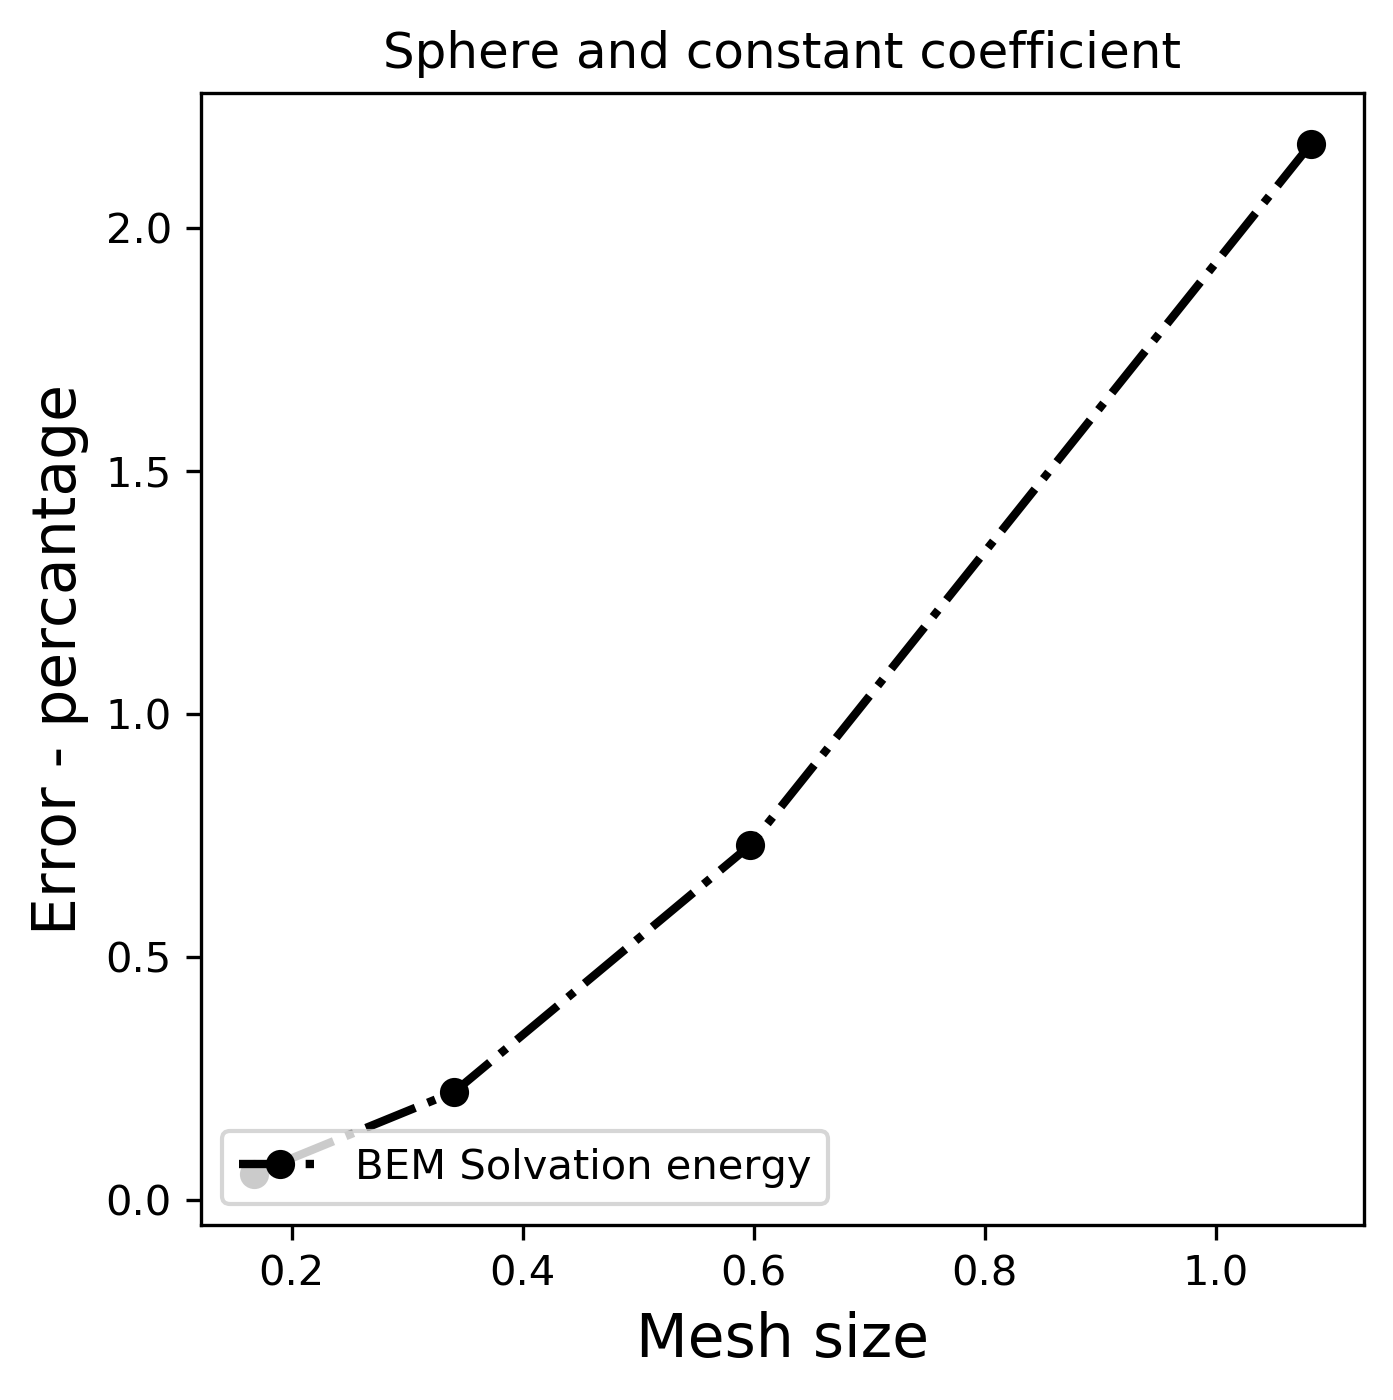

In [3]:
from operator import add
import matplotlib.pyplot as plt

# # mesh_size = list_radius
# log_mesh_size = np.log(mesh_size)
# inv_mesh_size =  np.true_divide(1, mesh_size)

# mult = abs(BEM_solv_error[len(mesh_size)//2]/mesh_size[len(mesh_size)//2])
# o_mesh_size = np.multiply(mult, mesh_size)

# mesh_pow_2 = np.multiply(mesh_size, mesh_size)
# mult = 1.5*abs(BEM_solv_error[len(mesh_size)//2]/mesh_pow_2[len(mesh_size)//2])
# o_mesh_pow_2 = np.multiply(mult, mesh_pow_2)

# mesh_pow_3 = np.multiply(mesh_pow_2, mesh_size)
# mult = abs(BEM_solv_error[len(mesh_size)//2]/mesh_pow_3[len(mesh_size)//2])
# o_mesh_pow_3 = np.multiply(mult, mesh_pow_3)

plt.figure( figsize=(5, 5), dpi=300)
# plt.loglog(mesh_size, error_between, 'ks-', linewidth=2, label='Relative Dirichlet jump')
plt.plot(mesh_size, solv_error, 'ko-.', linewidth=2, label='BEM Solvation energy')
# plt.loglog(mesh_size, o_mesh_size, 'k:', linewidth=1, label='O(h)')
# plt.loglog(mesh_size, o_mesh_pow_2, 'k:', linewidth=2, label='O(h^2)')
# plt.loglog(mesh_size, o_mesh_pow_3, 'k--', linewidth=1, label='O(h^3)')
plt.legend(loc='lower left')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Error - percantage', fontsize='x-large')
plt.show()

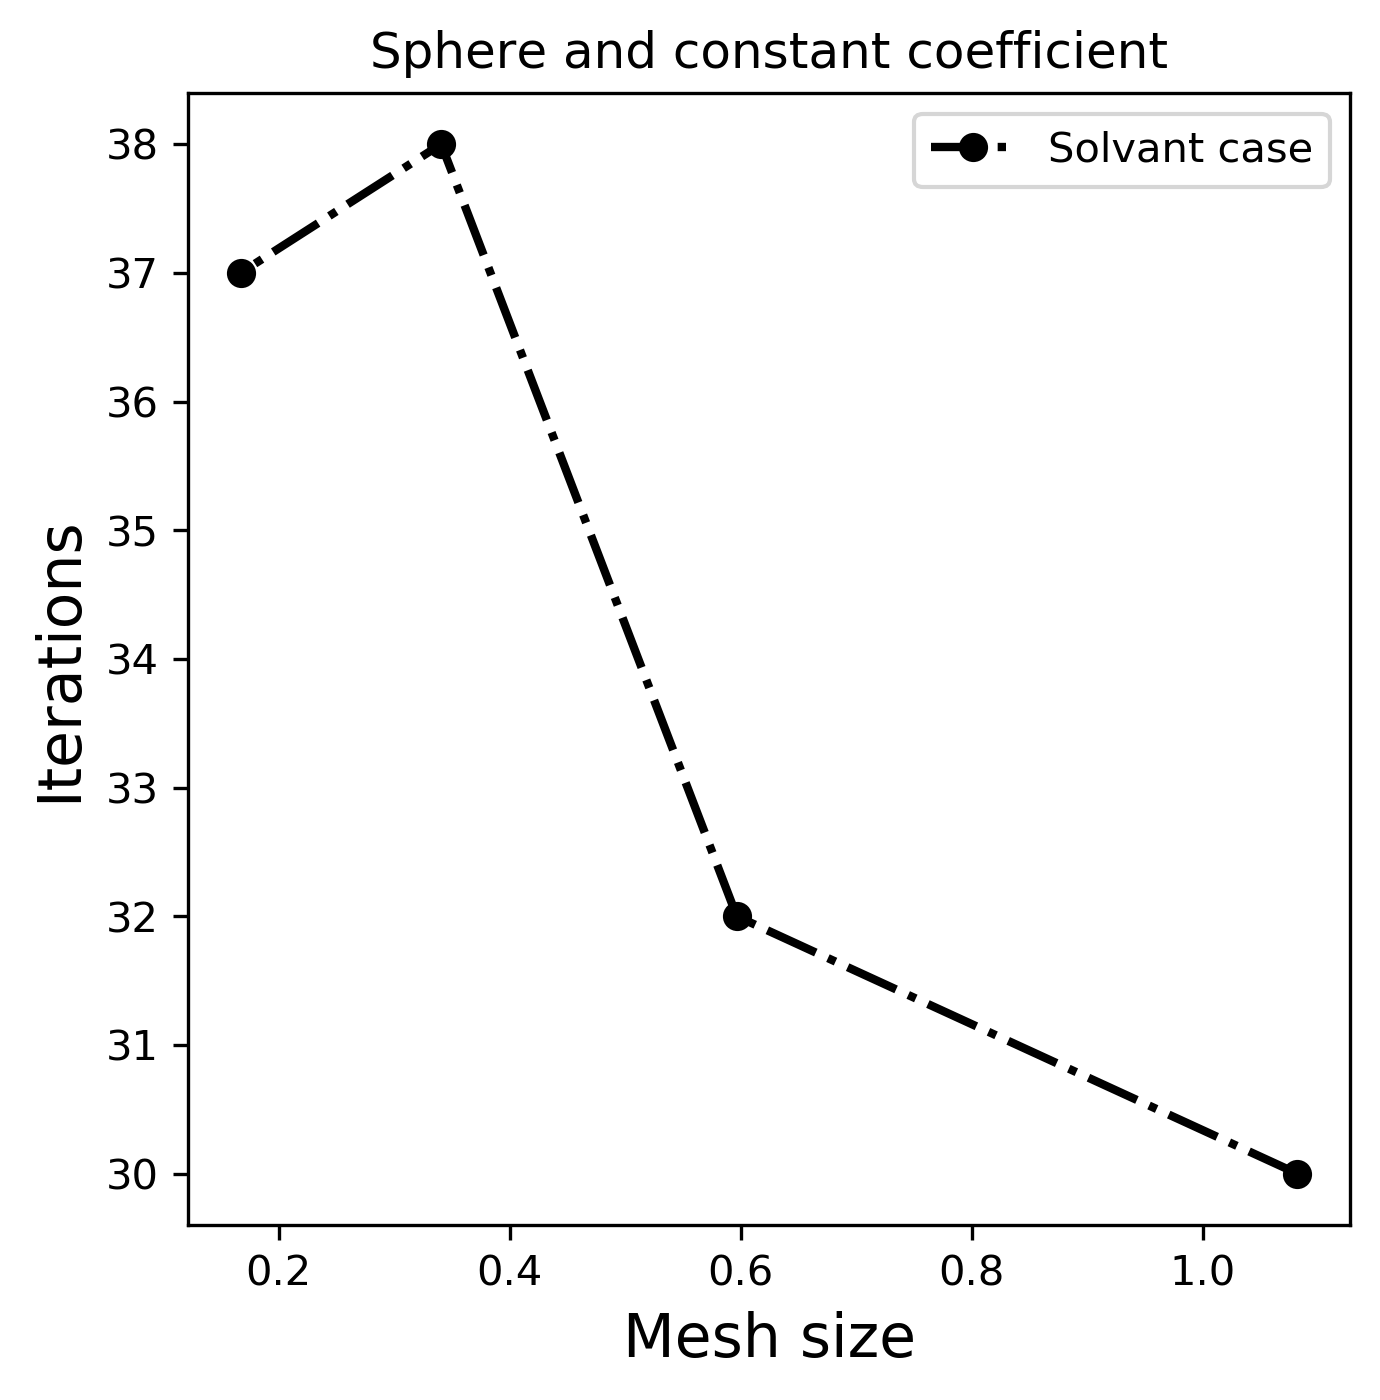

In [4]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, iter_num, 'ko-.', linewidth=2, label='Solvant case')
plt.legend(loc='upper right')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Iterations', fontsize='x-large')
plt.show()

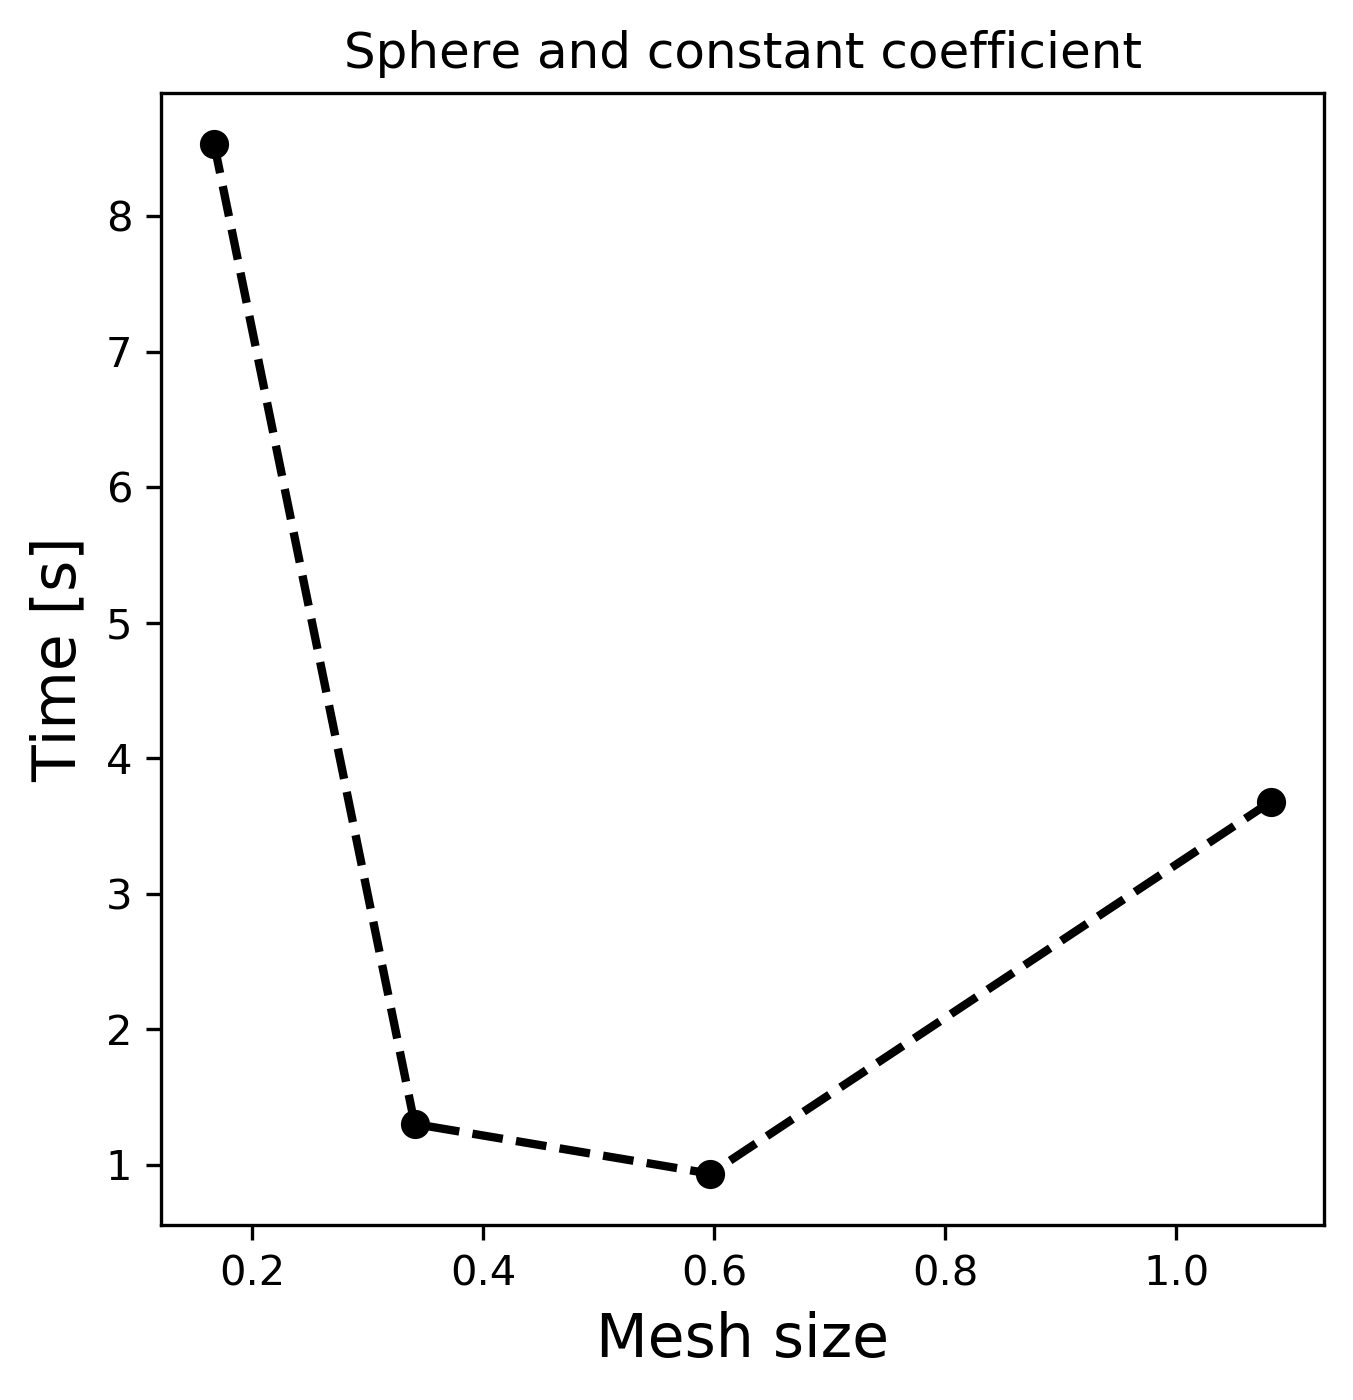

In [5]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, np.add(mesh_size, time_solve), 'ko--', linewidth=2)
# plt.plot(mesh_size, time_solve, 'ko--', linewidth=2, label='Solvant case')
# plt.plot(mesh_size, vac_time_solve, 'ko-', linewidth=2, label='Vacuum case')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()